# ATP Tennis Data - Reduced Feature Columns

For this notebook, I will remove some noise from our data to see if the models work better. Features that did not show up in our top 50 features from previous notebook where we combined history and matchup data will be used.

The following columns will be kept:

* p1_rank / p2_rank
* p1_history_games_won_percentage_diff
* p1_seed / p2_seed
* p1_height / p2_height
* p1_age / p2_age
* p1_matchup_games_won_percentage / p2_matchup_games_won_percentage
* p1_history_wins_diff
* p1_matchup_games_won_percentage / p2_matchup_games_won_percentage
* p1_matchup_sets_won_percentage/ p2_matchup_sets_won_percentage
* tourney_level_label
* surface_*
* best_of_*
* tourney_month
* p1_ioc_* (player origin)
* p1_* / p2_* (player id's)
* p1_history_sets_won_percentage_diff
* round_label


### Results from Best Model

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

# Summary of Results

Our results from Gradient Boosting is the following. Removing the rest of the features did little to affect the model accuracy (~0.3%)

```
Model Score: 0.6903443619176233

ROC/AUC Score: 0.6903161608528401
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-reduced_history_matchup"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [9]:
import re

def filter_features(data: pd.DataFrame):
    
    print(f'\nBefore: data.shape {data.shape}')

    new_features = data[["p1_rank", "p2_rank", "p1_seed", "p2_seed", "p1_history_games_won_percentage_diff", "p1_history_sets_won_percentage_diff", 
                        "p1_ht", "p2_ht", "p1_age", "p2_age", "p1_matchup_games_won_percentage", "p2_matchup_games_won_percentage",
                        "p1_history_wins_diff", "tourney_level_label", "p1_matchup_sets_won_percentage", "p2_matchup_sets_won_percentage",
                        "tourney_month", "round_label"]]
             
    surface_cols = [col for col in data.columns if re.match("surface_", col)]
    new_features = pd.concat([new_features, data[surface_cols]], axis=1)

    best_of_cols = [col for col in data.columns if re.match("best_of_", col)]
    new_features = pd.concat([new_features, data[best_of_cols]], axis=1)
             
    player_ioc_cols = [col for col in data.columns if re.match(r"(p1|p2)_ioc_", col)]
    new_features = pd.concat([new_features, data[player_ioc_cols]], axis=1)

    player_id_cols = [col for col in data.columns if re.match(r"(p1|p2)_[\d]+", col)]
    new_features = pd.concat([new_features, data[player_id_cols]], axis=1)


    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)

    


    print(f'After: data.shape {new_features.shape}')
    return new_features



Before: data.shape (44429, 5299)
After: data.shape (44429, 5044)

Before: data.shape (14810, 5299)
After: data.shape (14810, 5044)


In [8]:
X_train_orig, X_test_orig, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = feature_filter)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [10]:
print(f'Columns removed: {[col for col in X_test_orig.columns if col not in X_test.columns]}')

Columns removed: ['draw_size', 'tourney_year', 'p1_hand_l', 'p1_hand_r', 'p1_hand_u', 'p2_hand_l', 'p2_hand_r', 'p2_hand_u', 'tourney_id_0301', 'tourney_id_0308', 'tourney_id_0311', 'tourney_id_0314', 'tourney_id_0315', 'tourney_id_0316', 'tourney_id_0319', 'tourney_id_0321', 'tourney_id_0322', 'tourney_id_0328', 'tourney_id_0329', 'tourney_id_0337', 'tourney_id_0341', 'tourney_id_0352', 'tourney_id_0360', 'tourney_id_0375', 'tourney_id_0402', 'tourney_id_0407', 'tourney_id_0410', 'tourney_id_0414', 'tourney_id_0421', 'tourney_id_0424', 'tourney_id_0425', 'tourney_id_0429', 'tourney_id_0439', 'tourney_id_0451', 'tourney_id_0495', 'tourney_id_0496', 'tourney_id_0499', 'tourney_id_0500', 'tourney_id_0506', 'tourney_id_0533', 'tourney_id_0568', 'tourney_id_0605', 'tourney_id_0717', 'tourney_id_0741', 'tourney_id_0773', 'tourney_id_0891', 'tourney_id_1536', 'tourney_id_1720', 'tourney_id_201', 'tourney_id_215', 'tourney_id_224', 'tourney_id_2276', 'tourney_id_237', 'tourney_id_240', 'tourn

# Logistic Regression

In [11]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6648885887913571

ROC/AUC Score: 0.6648852874456246
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.67      0.67      0.67      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4900  2481
Win   2482  4947


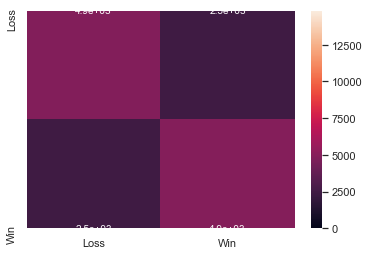

In [12]:
lr.analyze()

In [13]:
# ju.plot_2d(X_test, y_predict_lr)

In [14]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [15]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_knn = knn.predict()

Model Score: 0.6093855503038488

ROC/AUC Score: 0.6093930458395932
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4515  2866
Win   2919  4510


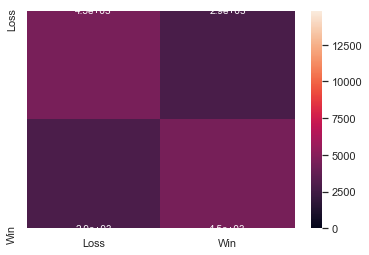

In [16]:
knn.analyze()

In [17]:
# ju.plot_2d(X_test, y_predict_knn)

In [18]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [19]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_dt = dt.predict()

Model Score: 0.6056718433490884

ROC/AUC Score: 0.6056830202309543
              precision    recall  f1-score   support

        Loss       0.60      0.61      0.61      7381
         Win       0.61      0.60      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4496  2885
Win   2955  4474


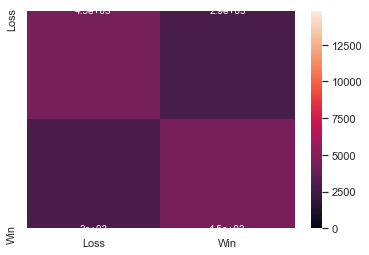

In [20]:
dt.analyze()

In [21]:
# ju.plot_2d(X_test, y_predict_dt)

In [22]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [23]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6345037137069548

ROC/AUC Score: 0.6347657704332988
              precision    recall  f1-score   support

        Loss       0.61      0.72      0.66      7381
         Win       0.66      0.55      0.60      7429

    accuracy                           0.63     14810
   macro avg       0.64      0.63      0.63     14810
weighted avg       0.64      0.63      0.63     14810

      Loss   Win
Loss  5282  2099
Win   3314  4115


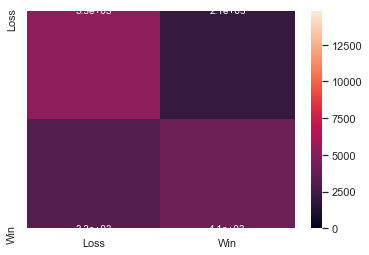

In [24]:
rf.analyze()

In [25]:
# ju.plot_2d(X_test, y_predict_rf)

In [26]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [27]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3661            9.57m
         2           1.3495           10.93m
         3           1.3353           11.63m
         4           1.3230           11.01m
         5           1.3124           10.56m
         6           1.3032           10.16m
         7           1.2958           10.22m
         8           1.2880            9.95m
         9           1.2814            9.70m
        10           1.2754            9.51m
        20           1.2280            7.84m
        30           1.2001            6.68m
        40           1.1878            5.79m
        50           1.1703            4.76m
        60           1.1606            3.79m
        70           1.1536            2.81m
        80           1.1508            1.86m
        90           1.1481           55.37s


Model Score: 0.6903443619176233

ROC/AUC Score: 0.6903161608528401
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5031  2350
Win   2236  5193


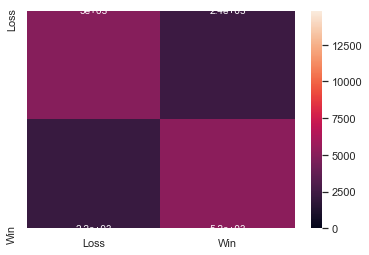

In [28]:
gb.analyze()

In [29]:
# ju.plot_2d(X_test, y_predict_gb)

In [30]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [31]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = feature_filter).fit()
y_predict_ab = ab.predict()

Model Score: 0.6681296421336934

ROC/AUC Score: 0.668101426558085
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66      7381
         Win       0.67      0.68      0.67      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4867  2514
Win   2401  5028


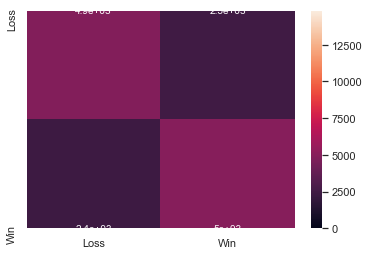

In [32]:
ab.analyze()

In [33]:
# ju.plot_2d(X_test, y_predict_ab)

In [34]:
ab.save()

Saving report: ../reports/summary.csv


# Results

In [35]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
120,LogisticRegression,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.664889,0.664885,"{""0"": {""0"": 4900, ""1"": 2482}, ""1"": {""0"": 2481,...","{""Loss"": {""precision"": 0.6637767542671362, ""re...",../models/logisticregression-1998-2018-ohe-red...,0.0,0.0,0.0
121,KNeighborsClassifier,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.609386,0.609393,"{""0"": {""0"": 4515, ""1"": 2919}, ""1"": {""0"": 2866,...","{""Loss"": {""precision"": 0.6073446327683616, ""re...",../models/kneighborsclassifier-1998-2018-ohe-r...,0.0,0.0,0.0
122,DecisionTreeClassifier,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.605672,0.605683,"{""0"": {""0"": 4496, ""1"": 2955}, ""1"": {""0"": 2885,...","{""Loss"": {""precision"": 0.6034089383975305, ""re...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0
123,RandomForestClassifier,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.634504,0.634766,"{""0"": {""0"": 5282, ""1"": 3314}, ""1"": {""0"": 2099,...","{""Loss"": {""precision"": 0.6144718473708701, ""re...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0
124,GradientBoostingClassifier,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.690344,0.690316,"{""0"": {""0"": 5031, ""1"": 2236}, ""1"": {""0"": 2350,...","{""Loss"": {""precision"": 0.6923076923076923, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,9.0,9.0
125,AdaBoostClassifier,ohe-reduced_history_matchup,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.668130,0.668101,"{""0"": {""0"": 4867, ""1"": 2401}, ""1"": {""0"": 2514,...","{""Loss"": {""precision"": 0.6696477710511832, ""re...",../models/adaboostclassifier-1998-2018-ohe-red...,0.0,1.0,1.0


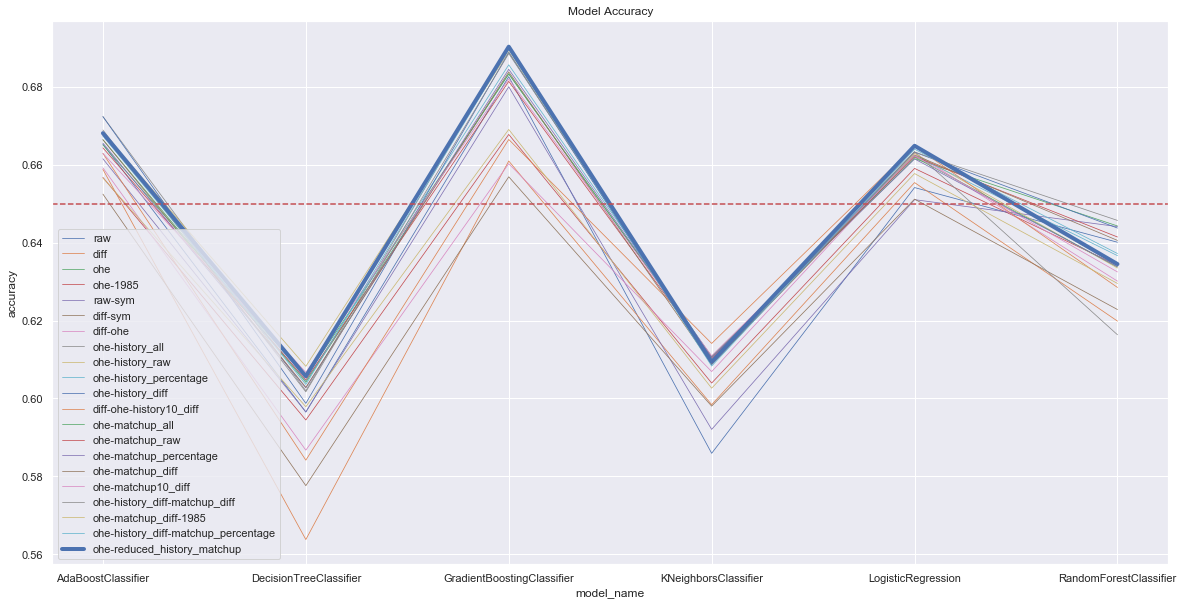

In [36]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


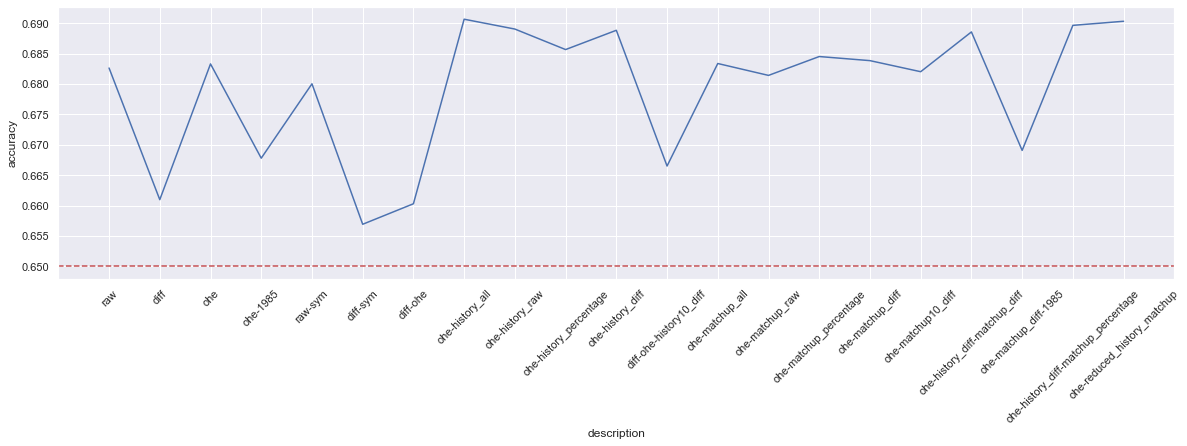

In [37]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [38]:

current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [39]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

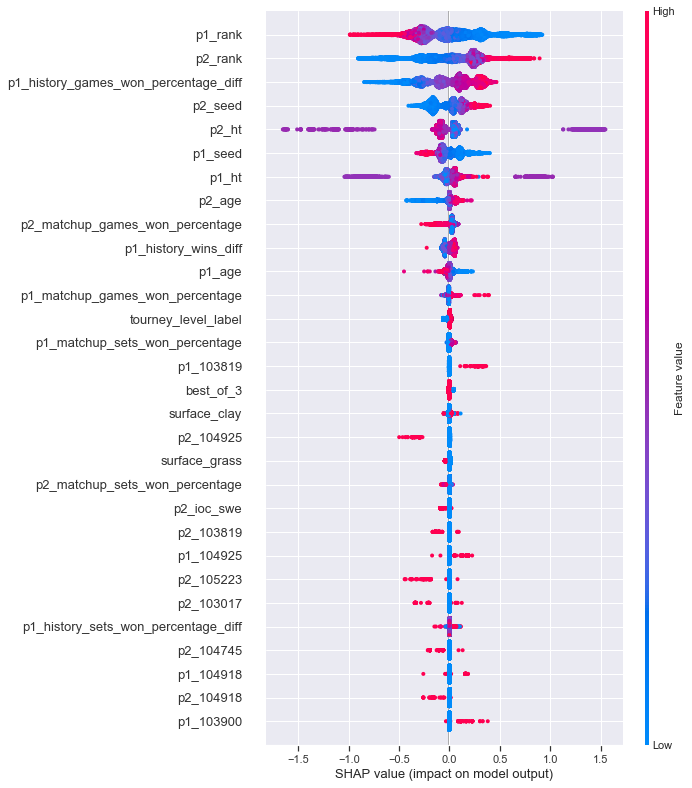

In [40]:
shap.summary_plot(shap_values, X_test, max_display=30)

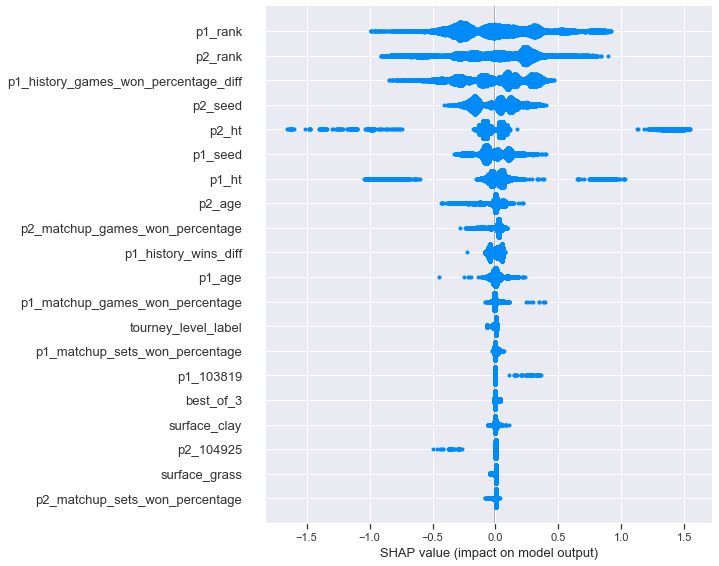

In [41]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [42]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-21 12:28
